# COVID-19 Research Corpus Analysis and Findings

# Introduction

This work has been conducted by myself ([Hadi Mahihenni](https://www.linkedin.com/in/hadimahihenni/)) and my wife, [Dr. Lilia Mecif](https://www.linkedin.com/in/lilia-mecif-702b4250/). We teamed up to bring our modest contribution to this challenge facing our livelihood. Lilia holds a PhD in Pharmacy, she brings her scentific experience in biology and scientific research and I am an engineer (with background in mathematics and physics) with high interest in data science. 

We welcome feedback so that we can continue to improve this project

# Goal & Problem Statement

COVID-19 Open Research Dataset (CORD-19) is a free resource of scholarly articles, aggregated by a coalition of leading research groups, about COVID-19 and the coronavirus family of viruses. The dataset can be found on [Semantic Scholar](https://pages.semanticscholar.org/coronavirus-research) and there is a research [challenge on Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) where all tasks could be consulted. 

This project builds a data-driven approach to analyse COVID-19 dataset in order to support researchers and scientists in their current active research around SARS-CoV-2 and hence accelerate future scientific discoveries and/or healthcare policies. 

We refer below to the different challenge tasks as the following : 
* Task 1 : What is known about transmission, incubation and environmental stability ?
* Task 2 : What do we know about COVID-19 risk factors ?
* Task 3 : What do we know about virus genetics, origin and evolution ?
* Task 4 : What do we know about vaccines and therapeutics ?
* Task 5 : What has been published about medical care ?
* Task 6 : What do we know about non-pharmaceutical interventions ? 

# Global Approach and Key results

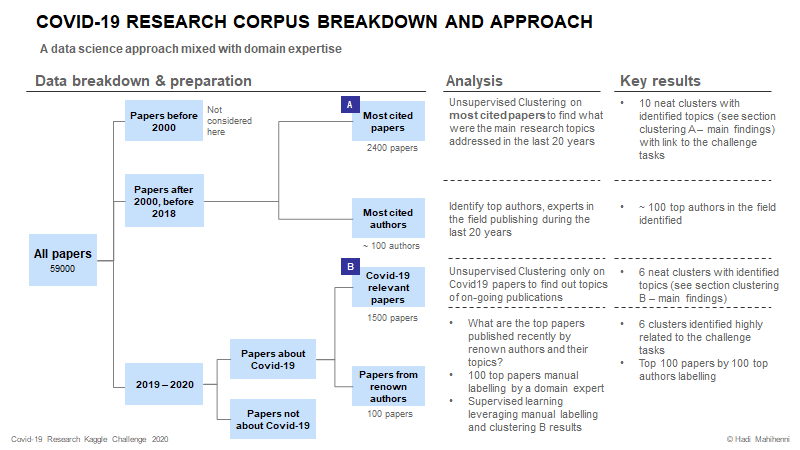


Our approach focused on articles published from the year 2000, two years before the emergence of SARS_COV and when the number of publications relating to the subject shows a significant increase in number (see chart below). This seems relevant to our tasks due to the similarity of the recent corona viruses outbreaks to the COVID-19 pandemic. We also assumed that any important information from before would have been considered when dealing with recent outbreaks and hence found in these articles.
 
Secondly, we considered important to identify the experts in the field and the articles that are viewed by the community as influential. Scientific brilliance of a research project and any articles resulting from it comes from being rigorous in theoretical concepts, methodological design and interpretive discussion. Comprehensive reviews can also hold such weight. Such articles are likely to be highly cited (although this can not be guaranteed) earning their author(s) prestige in the scientific community. From this principle we focused our search on articles that have been cited at least 10 times within the provided corpus.
 
This approach provided a neat clustering using kmeans algorithm with 10 clusters and feature engineering using Tf-Idf text vectoriser leveraging information from title, abstract and body text by using the respective weights (25%, 15% and 60%). In fact, in scientific research, title and abstract can accurately summarize the body of the paper that we thought should be considered in this task.
 
As cases resulting from SARS-COV2 infection have only been officially reported on December 2019, the above principle cannot be applied to recent papers treating the subject. Therefore, we split our approach into two steps.
 
First we prepared a relevant dataset by considering only the papers that:
 
·  	were published in 2019 and 2020.
·  	have a word count of covid-19 or SARS-CoV-2 greater than 10 times for the algorithm to consider it relevant.
 
Additionally, unsupervised clustering (k-mean) and tf-idf transformer was used to group articles by theme, then link them to the requested tasks. We iteratively analysed the found clusters with a domain expert to fine tune the number of clusters and the transformer weights. In fact, we reviewed the weights used above by giving more importance to the title and abstract since the body text of recent papers tends to mention all different aspects of the virus. Missing abstract have been replaced by top 200 words of the body text.
 
Neater clusters are found with (k = 6) and weights (title = 40%, abstract = 40% and body = 20%) after many iterations. Further clustering could be done on the body text only at the section level to be able to extract detailed information about method and material used, results, findings and discussion aspects.
 

We combined the results from sections A and B.  Identifying the most cited articles in task A, enabled us to generate a list of experts in the field. As the COVID-19 infection has only been known to us since November 2019, we could not use the number of citations as a calculating factor. To fine tune our selection, we identified authors with more than 10 publications who have been cited at least 50 times. 94 authors emerged from this crossover.  The latter had resulted in 90 articles. The domain expert clustered these articles in 6 more specific clusters and related them to the tasks for the challenge. This step could be considered as labelling for further “supervised clustering” and/or recommendation system for similar articles within the corpus. Meanwhile, this “manual” clustering could help any researcher in the field to get started with what the algorithms suggest are the “golden nuggets” papers. 



Below you will find the details of the data preparation, transformation and main findings. This work relies as well on other related works that are cited at the end of this publication. 

# Data Loading and Preparation

## Data Loading (meta data & json files) 

Importing important librairies for this notebook 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
!ls /kaggle/input/CORD-19-research-challenge/

Load metadata.csv as it includes more information about papers (e.g. publish_dates, journal, ..etc).  

In [ ]:
root_path = '/kaggle/input/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})

Insert a new column about the year of publication of each paper

In [ ]:
# Conversion of publish_time column to Datetime and add a column of year of publication
publish_dates = []
for d in meta_df['publish_time']:
    try:
        publish_dates.append(datetime.strptime(d,"%Y-%m-%d"))
    except Exception as e:
        if isinstance(d, str):
            publish_dates.append(datetime(int(d),1,1))
        else:
            publish_dates.append(datetime(1900,1,1))

meta_df.drop('publish_time',axis=1)
meta_df['publish_time'] = publish_dates
meta_df['year'] = meta_df['publish_time'].apply(lambda x: x.year)

meta_df.info()

Let's start by check meta data. First, can we rely on the "sha" as primary key for each paper ? 

In [ ]:
meta_df[meta_df['sha'].isnull()]

Too many papers (more than 13000 papers) are without a "sha" code ! Let's see if we can use the cord_uid instead ?

In [ ]:
len(meta_df['cord_uid'].unique())

More than 51000 (over 59000 papers as of April 15th) has got a cord_uid unique code ! We will rely on this "primary key" for the rest of the note book.

## Fetch All of JSON File Path

Get path to all JSON files

In [ ]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

# Data preparation for citations count and clustering

In the following long script, we prepare two dataframes : 
1. df_covid19 that include (cord_uid, title, abstract and body_text) that will feed the clustering pipeline
2. df_bibrefs that will be used to compute the citations count per paper & author

In [ ]:
# dictionary to build df_covid19 dataset for the unsupervised clustering
dict_1={'cord_uid': [], 'title':[], 'abstract':[], 'body_text':[]}

# Dictionary that will include [paper_id and its cited_papers] useful for the most cited papers calculation
dict_2={'cord_uid':[], 'year' :[], 'title':[]}

# function that gets paper id based on its sha code or title if sha code does not exit
def get_paper_id(meta_df,sha,title):
    # try to get metadata information thru sha
    meta_data = meta_df.loc[meta_df['sha'] == sha]['cord_uid']
    # no metadata, get cord_uid thru the title
    if len(meta_data) == 0:
        p_id = meta_df.loc[meta_df['title'] == title]['cord_uid']
    else:
        p_id = meta_df.loc[meta_df['sha'] == sha]['cord_uid']
    return p_id

for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    # Open the content of each json file
    content = json.load(open(entry))
    
    ################ get the paper id from meta_df
    paper_id = get_paper_id(meta_df, content['paper_id'], content['metadata']['title'])
    
    if paper_id.empty:
        continue
    else:
        paper_id = paper_id.iloc[0]
    
    ## get meta_data
    meta_data = meta_df.loc[meta_df['cord_uid'] == paper_id]

    ################# get title, abstract and body_text
    # Append paper id
    dict_1['cord_uid'].append(paper_id)
    # get paper title
    paper_title = content['metadata']['title']
    # if title is empty in json data, get it from meta data
    if len(paper_title)==0:
        dict_1['title'].append(meta_data['title'].values[0])
    else:
        dict_1['title'].append(paper_title)
    
    abstract=[]
    body_text =[]
    
    # if abstract is not provided in json data, get it from meta data
    try:
        # try getting data from the json file
        for a in content['abstract']:
            abstract.append(a['text'])
        
        if len(abstract)==0:
            abstract = meta_data['abstract'].values[0]
        else:
            # join abstract 
            abstract = ''.join(str(abstract))
    # otherwise get it from meta data
    except Exception as e:
        abstract= meta_data['abstract'].values[0]
    
    
    # get body text
    for t in content['body_text']:
        body_text.append(t['text'])
    
    # join body text
    body_text = ''.join(body_text)
    
    # cap body_text length to 1 million characters (spacy constraint)
    if len(body_text) > 1000000:
        body_text = body_text[0:999999]
    
    dict_1['abstract'].append(abstract)
    dict_1['body_text'].append(body_text)
    
    ################## get all biliographic references (BIBREF)
    refs = []
    for e in content['bib_entries']:
        refs.append(e)
        
    # get cited references of this paper
    bib_entries = content['bib_entries']
    
    for ref in refs:
        dict_2['cord_uid'].append(paper_id)
        dict_2['year'].append(str(bib_entries[ref]['year']))
        dict_2['title'].append(bib_entries[ref]['title'])
        

df_covid19 = pd.DataFrame(dict_1,columns=['cord_uid','title','abstract','body_text'])
df_bibrefs = pd.DataFrame(dict_2, columns=['cord_uid','year','title'])
df_covid19.head()

We can inspect these two important dataframes by looking into their heads

In [ ]:
df_covid19.head()

In [ ]:
df_bibrefs.head()

# Citations Count


## Citation count per paper

First, we need to create a foreign key (year - title) in df_bibrefs to be able to groupby cited articles and count their occurrence within the corpus. Then join meta_df & df_bibrefs on this foreign key to able to have the citation count with the primary key (cord_uid)

In [ ]:
# Function to create a foreign key combining the year and the title of each cited article
def f(x,y):
    return str(x) + '-' + str(y)

df_bibrefs['key'] = df_bibrefs.apply(lambda x: f(x.year, x.title), axis = 1)

In [ ]:
# groupby and count to estimate the number of occuerence of each cited paper within the corpus
new_df_bibrefs = df_bibrefs.groupby('key').count()

In [ ]:
# drop year and title columns to keep only cord_uid and key as index
new_df_bibrefs = new_df_bibrefs.drop(['year', 'title'] , axis = 1)

In [ ]:
# creating the foreign key (year - title) within meta_df
meta_df['key'] = meta_df.apply(lambda x: f(x.year, x.title), axis =1)

In [ ]:
# we reset key index
new_df_bibrefs= new_df_bibrefs.reset_index()

Finally, merge meta_df and new_df_bibrefs to have citation count in this new datafrme called (df)

In [ ]:
df = pd.merge(meta_df,new_df_bibrefs, on='key', suffixes=('','_y'))
df = df.sort_values(by=['cord_uid_y'], ascending = False)
df = df.rename(columns= {'cord_uid_y' : 'nb_citations'})

In [ ]:
df.shape

After plotting the evolution of the number of publications per year, we see a significant increase of scientific research after 2000 with several virus outbreak that happend in the 2000's and 2010's. This justifiy the assumption that we took in our approach to focus only on papers published after 2000; 

In [ ]:
df.groupby(by=['year']).count()['cord_uid'].plot(kind='bar')

A this stage, we acheived the citation count per paper. Now we need to acheive it on the author level. 

## Citations count per author (+ number of publications)

Start by building a datafrme df_authors by splitting authors from meta_df

In [ ]:
dict_={'cord_uid' :[], 'authors' : []}

for i in range(0, len(df)):
    
    authors = str(df['authors'].iloc[i]).split(';')
    paper_id = df['cord_uid'].iloc[i]
        
    for author in authors:
        dict_['cord_uid'].append(paper_id)
        dict_['authors'].append(author)
        
df_authors = pd.DataFrame(dict_, columns=['cord_uid','authors'])

In [ ]:
df_authors.head()

### 1. Number of publications

Then we calculate the number of publications by author in the corpus by groupby & count on authors column.

In [ ]:
df_authors_pub = df_authors.groupby('authors').count()

In [ ]:
# we reset key index
df_authors_pub= df_authors_pub.reset_index()
# filter only on rows without NaN
df_authors_pub = df_authors_pub.sort_values(by=['cord_uid'], ascending = False)[['authors','cord_uid']]

In [ ]:
# remove nan line
df_authors_pub= df_authors_pub.drop(index=0)

### 2. Number of citations

We also calculate the number of citations per author (= number of publications x number of citations per paper)

In [ ]:
# Merge df_authors with df to get the number of citations per paper
df_authors = pd.merge(df_authors, df, on= 'cord_uid', suffixes =('','_y'))

Delete rows without an author

In [ ]:
df_authors = df_authors[df_authors['authors'].notna()]

In [ ]:
# Groupby on authors and sum of the number of citations
df_authors_cited = df_authors.groupby(by=["authors"])['nb_citations'].sum().reset_index().sort_values("nb_citations", ascending=False)

In [ ]:
df_authors_cited.head()

## Generate scatter plot : (publications vs citations) per author 
Objective : Find out who are the experts in the field and renown authors

In [ ]:
df_plot = df_authors_pub.merge(df_authors_cited, on='authors')
df_plot = df_plot.drop_duplicates('authors')
df_plot = df_plot.rename(columns={'cord_uid': 'nb_publications'})

In [ ]:
df_plot = df_plot[df_plot['nb_publications']>10]

In [ ]:
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput, RadioButtonGroup
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox

output_notebook()
source = ColumnDataSource(df_plot)
tools = "hover, box_zoom, undo, crosshair"
p = figure()
p.scatter('nb_publications', 'nb_citations', source = source,alpha=1)

p.add_tools(
    HoverTool(
        tooltips=[('Author', '@authors'), ('Nb citations','@nb_citations'), ('Nb publications', '@nb_publications')]
    )
)
show(p)

As we can see there is high correlation between number of publications and citations. We also can see there are two top experts in the field with the highest number of publication and citations (Dr. Yuen, Know-Young and Dr Drosten, Christian). For further focus on the best expertise in the field, we will only consider authors who have : 
1. Number of publications > 20
2. Number of citations > 100

We will look to later into recent publications about Covid 19 published by these authors. 

# Clustering (A) : most cited papers

## Clustering pipeline implementation

We first define the dataset corresponding the scope of this clustering (A), i.e. most cited papers (more than 10 citations), published after 2000

In [ ]:
df_scope = df[(df.nb_citations >10) & (df.year >2000)]
df_scope = df_scope[['cord_uid','nb_citations']]
df_cluster = pd.merge(df_scope,df_covid19, on='cord_uid')
df_cluster = df_cluster.sort_values(by=['nb_citations'], ascending = False)
df_cluster.head()

We drop duplicates and caste abstract to avoid float errors

In [ ]:
df_cluster.drop_duplicates(subset ='cord_uid', keep='first',inplace=True)
df_cluster['abstract'] = df_cluster['abstract'].apply(lambda x: str(x))
df_cluster.shape

We run the below clustering script to instanciate the data pipeline

In [ ]:
import spacy
import string
import re
import time
from collections import Counter

# Spacy imports
from spacy.lang.en.examples import sentences
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

#Skit learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    # using str to avoid float values error
    return str(text).strip().lower()

# Named entities extractors
# Load English NLP object (long size for entities recognition and GloVe vectorisation)
nlp= spacy.load('en_core_web_lg')


# Create our list of punctuation marks
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

# Creating our tokenizer function (w/o named entities)
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations  and len(word) > 2]
    # return preprocessed list of tokens
    return mytokens

# Custom transformer using spaCy
class Cleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

clusterer = KMeans(n_clusters=10, random_state = 42)

pipeline = Pipeline([
    # Use ColumnTransformer to combine the features from title, abstract and body text
    ('union', ColumnTransformer(
        [
            # Pulling features from the article's title line (first column)
            ('title', TfidfVectorizer(tokenizer=spacy_tokenizer), 0),
            
            # Pipeline for standard bag-of-words model for article (second column)
            ('abstract_bow', Pipeline([
                ('clean', Cleaner()),
                ('tfidf_abstract', TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=2**9, max_df=0.6, min_df=10)),
                ('best', TruncatedSVD(n_components=50)),
            ]), 1),

            # Pipeline for standard bag-of-words model for article (second column)
            ('body_bow', Pipeline([
                ('clean', Cleaner()),
                ('tfidf_body', TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=2**12, max_df=0.6, min_df=10)),
                ('best', TruncatedSVD(n_components=50)),
            ]), 2),

        ],

        # weight components in ColumnTransformer
        transformer_weights={
            'title': 0.25,
            'abstract_bow':0.15,
            'body_bow': 0.60,
            #'named_entities': 1,
        }
    )),

    # Use a k-mean clusterer on the combined features
    ('kmean', clusterer ),
])

Apply pipeline to the prepared dataset (df_cluster)

In [ ]:
data_a = df_cluster[['title','abstract','body_text']]
X_a = pipeline.fit_transform(data_a)
labels_a = pipeline.predict(data_a)
data_a['labels'] = labels_a

Now that we computed our labels (clusters), we need to prepare our clustering display using dimensionality reduction by T-SNE

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
y = labels_a
tsne = TSNE(verbose=1)
X_embedded_a = tsne.fit_transform(X_a)

In [ ]:
# Prepare data for display 
def get_breaks(content, length):
    data = ""
    words = str(content).split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

df_cluster['title_display'] = df_cluster['title'].apply(lambda x: get_breaks(x,40))
df_cluster['abstract_display'] = df_cluster['abstract'].apply(lambda x: ' '.join(x.split(' ')[:100])) 
df_cluster['abstract_display'] = df_cluster['abstract'].apply(lambda x: get_breaks(x,40)) 

Adding journal and authors columns, useful for clusters display

In [ ]:
df_temp = df_cluster.merge(meta_df, on='cord_uid', suffixes = ('','_y'))
df_cluster['journal'] = df_temp.drop_duplicates('cord_uid')['journal']
df_cluster['authors'] = df_temp.drop_duplicates('cord_uid')['authors']

In [ ]:
# Generating the clustering display
output_notebook()
y_labels = labels_a

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded_a[:,0], 
    y= X_embedded_a[:,1],
    x_backup = X_embedded_a[:,0],
    y_backup = X_embedded_a[:,1],
    desc= y_labels, 
    titles= df_cluster['title_display'],
    authors = df_cluster['authors'],
    journal =df_cluster['journal'],
    abstract = df_cluster['abstract_display'],
    labels = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
], point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE Most cited papers last 20 years, Clustered(K-Means), Tf-idf with Title, Abstract and  Plain Text", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend_group = 'labels')


#header
header = Div(text="""<h1> Most cited papers clustering 2000 - 2020 </h1>""")

# show
show(column(header,p))

### Saving clustering results 
Since our clustering methodology is not 100% reproducible, we save here the results (output repo). They could be loaded later to reproduce the same results that we comment here. 

In [ ]:
# How to save clustering data
data_a.to_csv('clustering_A.csv', index=False)
outcome = pd.DataFrame(X_a)
outcome.to_csv('X_clustering_A.csv',encoding='utf-8', index = False)

# How to load a saved clustering later
# data_a = pd.read_csv('clustering_A.csv')
# labels_a = data['labels']
#X_a = pd.read_csv('X_clustering_A.csv').to_numpy()

## Main findings and link to the challenge tasks

Clustering may vary because the nature of the algorithms used (unsupervised) but more/less the same clusters tend to clearly appear. As you can see in the figure below, clusters tend to group articles about various respiratory viruses outbreaks during the last 20 years. Others group precious articles about prevention, virus transmission, impact of environment, molecular immune response, ..etc.

These clusters could be found in the input repo (Clustering A results) or consulted here in [this notebook](https://www.kaggle.com/hadimahihenni/clustering-a-visualisation/). 

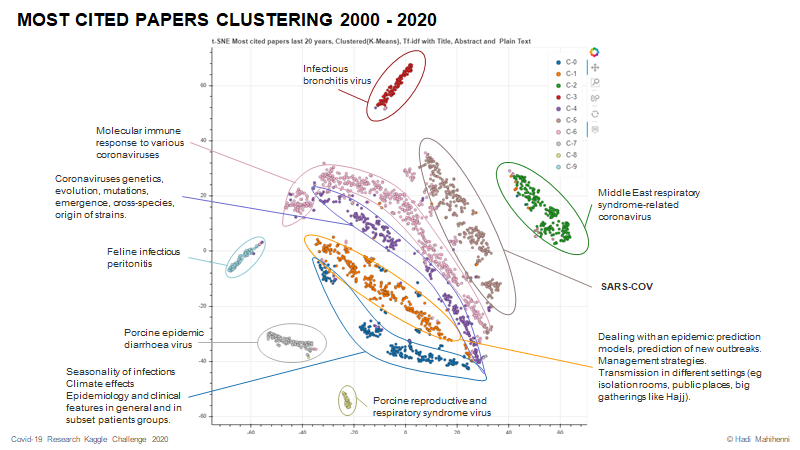

We performed a clear link between each cluster and the requested tasks of the challenge.

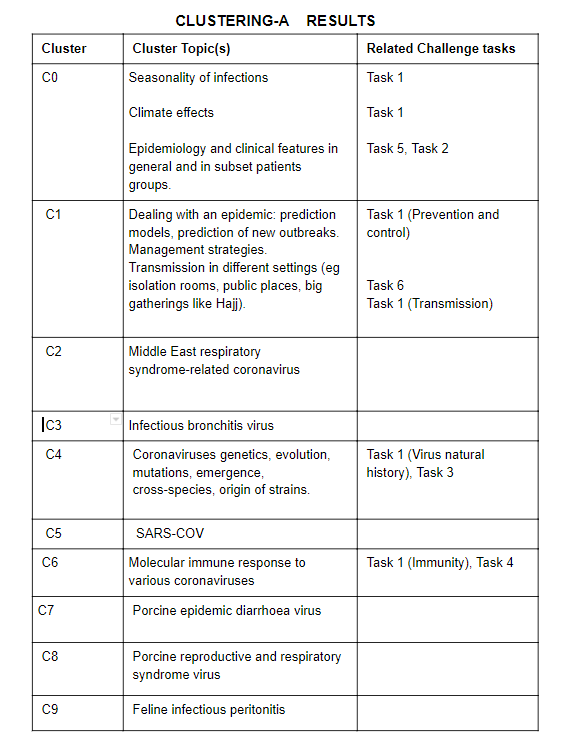

# Clustering (B) : Covid-19 papers

## Data preparation

We first start by identifying all articles that talk about Covid-19 or SARS-CoV-2 at least once by counting these words in the title, abstract and body text. 

In [ ]:
def find_virus(x):
    count = 0
    x = str(x)
    count += x.lower().count('covid-19')
    count += x.lower().count('sars-cov-2')
    return count

df_covid19['covid-19']= df_covid19[['title','abstract','body_text']].apply(lambda x: find_virus(x.title)+find_virus(x.abstract)+find_virus(x.body_text),axis=1)

We will consider on only papers that talk about covid19 more than 10 times ...

In [ ]:
df_only_covid19 = df_covid19.loc[df_covid19['covid-19']>10].sort_values(by=['covid-19'], ascending=False)
# Removing duplicates
df_only_covid19.drop_duplicates(subset ='cord_uid', keep='first',inplace=True)

In [ ]:
df_only_covid19.shape

... and papers that are published after 2018 (ie. in 2019 and 2020)

In [ ]:
df_only_covid19 = df_only_covid19.merge(meta_df, on='cord_uid', suffixes=('', '_y'))
df_only_covid19 = df_only_covid19[df_only_covid19['year']>2018]
df_only_covid19.drop_duplicates(subset ='cord_uid', keep='first',inplace=True)

In [ ]:
# populating titles that say "Comment" with title from meta_df
df_only_covid19['title'] = df_only_covid19[['title','title_y']].apply(lambda x: x.title_y if x.title=='Comment' else x.title, axis=1)

In [ ]:
# populating null abstracts by the top 200 words of the body text (it is just a workaround to avoid having a cluster with only papers with null abstract)
df_only_covid19['abstract'] = df_only_covid19['abstract'].fillna('missing')
df_only_covid19['abstract'] = df_only_covid19[['abstract','body_text']].apply(lambda x: ' '.join(x.body_text.split(' ')[:200]) if x.abstract =='missing' else x.abstract, axis=1)

## Clustering pipeline implementation

Instantiate the pipeline with 6 clusters ...

In [ ]:
clusterer = KMeans(n_clusters=6, random_state = 42)


pipeline = Pipeline([
    # Use ColumnTransformer to combine the features from title, abstract and body text
    ('union', ColumnTransformer(
        [
            # Pulling features from the article's title line (first column)
            ('title', TfidfVectorizer(tokenizer=spacy_tokenizer), 0),
            
            # Pipeline for standard bag-of-words model for article (second column)
            ('abstract_bow', Pipeline([
                ('clean', Cleaner()),
                ('tfidf_abstract', TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=2**8, max_df=0.6, min_df=10)),
                ('best', TruncatedSVD(n_components=50)),
            ]), 1),

            # Pipeline for standard bag-of-words model for article (second column)
            ('body_bow', Pipeline([
                ('clean', Cleaner()),
                ('tfidf_body', TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=2**12, max_df=0.6, min_df=10)),
                ('best', TruncatedSVD(n_components=50)),
            ]), 2),

        ],

        # weight components in ColumnTransformer
        transformer_weights={
            'title': 0.4,
            'abstract_bow':0.4,
            'body_bow': 0.2,
        }
    )),

    # Use a k-mean clusterer on the combined features
    ('kmean', clusterer ),
])

... launch the fitting, transformation and dimensionality reduction with T-SNE ...

In [ ]:
data = df_only_covid19[['title','abstract','body_text']]
X = pipeline.fit_transform(data)
labels = pipeline.predict(data)
data['labels'] = labels
X_embedded = tsne.fit_transform(X)

... and prepare clustering results display 

In [ ]:
df_only_covid19['title_display'] = df_only_covid19['title'].apply(lambda x: get_breaks(str(x),40))
df_only_covid19['abstract_display'] = df_only_covid19['abstract'].apply(lambda x: ' '.join(str(x).split(' ')[:100])) 
df_only_covid19['abstract_display'] = df_only_covid19['abstract'].apply(lambda x: get_breaks(str(x),40)) 

In [ ]:
output_notebook()
y_labels = labels

title = df_only_covid19['title']
title = [text[0:40] for text in title]

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df_only_covid19['title_display'],
    authors = title,
    journal =title,
    abstract = df_only_covid19['abstract_display'],
    labels = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE Covid-19 Articles, Clustered(K-Means), Tf-idf with Title, Abstract & Plain Text", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')

#header
header = Div(text="""<h1>COVID-19 Research Papers Cluster - 2019/2020 </h1>""")

# show
show(column(header,p))

### Saving clustering results

In [ ]:
# How to save clustering data
data.to_csv('clustering_B_final.csv', index=False)
outcome = pd.DataFrame(X)
outcome.to_csv('X_clustering_B_final.csv',encoding='utf-8', index = False)


## Main findings and link to tasks

Two different runs of the covid-19 papers result in the emergence of similar 6 clusters highlighted below : 
- C0 : Models predicting pandemic, transmission dynamics and non pharmacy intervention (related to Task 1)
- C1 : Clinical characterisation, diagnosis, treatment, symptoms (beyond lungs) (related to Task 2)
- C2 : Testing, diagnostics & detection protocols (related to Task 1 - Clinical process)
- C3 : Healthcare workers impact, patients subgroups, coping strategies in different medical departments (Related to Task 2)
- C4 : Covid-19 features (structure, genetics, origin, evolution, mutation) + Molecular immune response and potential treatments / vaccines (related to Task 3 and Task 4)
- C5 : General reviews


Data is provided for the clusters on the left in the slide below. To consult the clustering results commented below, please see [this notebook](https://www.kaggle.com/hadimahihenni/clustering-b-visualisation)

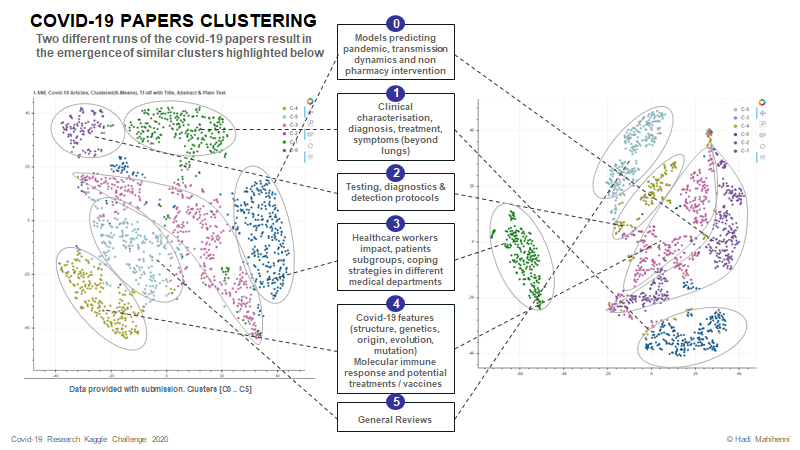

# What are the recent papers published by the field experts and their main topics ? 

As mentioned before, we will consider only authors with more than 10 publications and 50 citations in the corpus. 

In [ ]:
df_plot = df_plot.loc[df_plot['nb_publications']> 10]

In [ ]:
df_experts = df_plot.loc[df_plot['nb_citations']> 50]

In [ ]:
experts = df_experts['authors'].tolist()

Let's flag the papers that are published by the top experts in the field

In [ ]:
def check_author(x):
    count = 0
    authors = str(x).split(';')
    for author in authors:
        if author in experts:
            count+=1
    return count

df_only_covid19['by_expert'] = df_only_covid19['authors'].apply(lambda x: check_author(x))

Let's display the top papers from top experts ! There are 34 papers that are must read to start any research about COVID-19

In [ ]:
pd.set_option('display.max_colwidth', -1)
df_top_papers = df_only_covid19[df_only_covid19['by_expert']>0][['title','abstract','authors', 'cord_uid']]
df_top_papers.to_excel('100_top_papers.xlsx')

## Labelisation phase by an expert

In [ ]:
root_path = '/kaggle/input/100-top-papers-labelling/'
labelling_path = f'{root_path}/100_top_papers_labelling.xlsx'
df_labels = pd.read_excel(labelling_path)

In [ ]:
df_labels = df_labels.rename(columns = {'Title' : 'title'})
df_labels = df_labels.drop(['index'], axis=1)

In [ ]:
df_top_papers = df_top_papers.merge(df_labels, on='title')

In [ ]:
df_top_papers

Let's plot the number of article per class. As we can see, we need to label more articles for class 2 and 5 to have a balanced sample. We can enrich this sample with articles from Clustering B and carry-out a supervised approach for the whole corpus. This could be done as a next step after Round 1. 

In [ ]:
df_top_papers.groupby('label').count()['title'].plot(kind ='bar')

## Main findings and link to tasks

This is an overview of the labels found by reading the top 100 papers and their link to the challenge tasks (see also 100-top-covid19-papers dataset in the input repo). This work could be combined with the clustering B in order to build a labeled bigger dataset to train a supervised ML model that could be generalised to the whole corpus.  

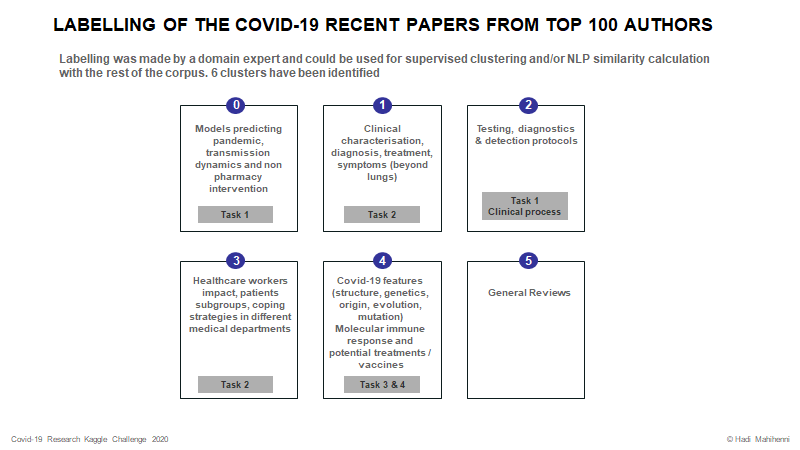

# Conclusion and way forward

Our analytical approach allowed us to distinguish two main types of information to be dissected later in greater details, articles before and after COVID-19 emergence. This approach enabled us to separate our well established knowledge of viruses that belong to the same family as the COVID-19, their genetics, structure, transmision, evolution, mutation, clinical and epidemiological characteristics and current treatment or prevention protocols. It also give a great insight of non-pharmaceutical methods that can be applied for the prevention of global pandemics, their management and their social and economics impacts. These articles can be used by experts in the field as a starting point and also as a reservoir for generating predictive models. In the absence of time for conventional research methods, we can turn to artificial intelligence. The information gathered on the coronavirus family can be fed into models, that can based on differences and similarities predict vital information on COVID-19 and even used for the development of a vaccine.


Varying the number of clusters and the features weights, we managed to cluster the articles published after the surfacing of the first case of COVID-19 infection in 6 prominent categories. This can be of particular importance for researcher with different interests in the infection and can be a great tool to filter through particular topic. Equally, this clustering can be of use to generate clinical, treatment and management protocols, identifying risk factors and patient groups at risk.

The approach we adopted allowed us to identify the most renowned authors in the field. Due to the limited time scope, we considered articles published by these authors after the emergence of COVID-19 of higher credibility. They can be used as solid references in ongoing research. These can be a great source of information for collaborations across the globe. These articles were manually labelled in accordance with clustering B. Interestingly, there was no need to create new subclusters, which validates our model. 

The next step would be to combine manual and automatic labels found in clustering B to train a supervised model that could be expanded to the whole corpus.

# Citations

[Cite : COVID-19 Litterature Clustering](https://www.kaggle.com/maksimeren/covid-19-literature-clustering)

@inproceedings {COVID-19 Literature Clustering,
    author = {Eren, E. Maksim. Solovyev, Nick. Nicholas, Charles. Raff, Edward},
    title = {COVID-19 Literature Clustering},
    year = {2020},
    month = {April},
    location = {University of Maryland Baltimore County (UMBC), Baltimore, MD, USA},
    note={Malware Research Group},
    url = {\url{https://github.com/MaksimEkin/COVID19-Literature-Clustering}},
    howpublished = {TBA}
}

[Cite : COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Disclaimer
This publication does not represent the thoughts or opinions of my employer, nor uses its assets. It is solely based on our personal views and on our own initiative as citizens of the world